# plot maps of regrided chlorophyll fields
# Fig. 1 in CESM storms paper

In [1]:
import os
from tqdm import tqdm
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset, MFDataset
import numba as nb
import time as timing
from numba import njit 
from math import sin, cos, sqrt, atan2, radians
from geopy.distance import distance
import seawater as sw
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [2]:
#---
# general settings
#---

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/maps_regridded_fields/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    

In [3]:
#---
# load data
#---

vari1 = 'totChl'
vari2 = 'totChl_hr'
vari3 = 'totChl_emulator'

path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_chl/'
path2 = '/global/cfs/cdirs/m4003/cnissen/CESM_HIGH_RES_chl_regridded/'
path3 = '/global/cfs/cdirs/m4003/cnissen/CESM_totChl_emulator_regridded/'

year_list = np.arange(1997,2018+1,1)

data3 = np.nan*np.ones([len(year_list),320,640])
for yy in tqdm(range(0,len(year_list))):

    year = year_list[yy]

    file1 = vari1+'_JRA_grid_'+str(year)+'-01-01.nc'
    file2 = vari2+'_JRA_grid_'+str(year)+'-01-01.nc'
    file3 = vari3+'_JRA_grid_'+str(year)+'-01-01.nc'

    # for time averaging (option here to only consider certain days/months)
    ind1,ind2 = 0,365 #300,331 #0,365

    # LOW RES full chl field
    ff  = xr.open_dataset(path1+file1)
    if yy==0:
        data1 = ff[vari1][ind1:ind2,:,:].mean(axis=0).values
    else:
        data1 = data1+ff[vari1][ind1:ind2,:,:].mean(axis=0).values
    if yy==0: # only do once
        lat = ff['latitude'][:].values
        lon = ff['longitude'][:].values
        # for plotting
        lat2,lon2 = np.meshgrid(lat,lon)
        lat2 = lat2.transpose()
        lon2 = lon2.transpose()
    ff.close()

    # HIGH RES
    ff  = xr.open_dataset(path2+file2)
    if yy==0:
        data2 = ff[vari1][ind1:ind2,:,:].mean(axis=0).values
    else:
        data2 = data2+ff[vari1][ind1:ind2,:,:].mean(axis=0).values
    ff.close()

    # LOW RES emulator chl field 
    ff  = xr.open_dataset(path3+file3)
    data3[yy,:,:] = ff[vari1+'_masked'][ind1:ind2,:,:].mean(axis=0).values
    ff.close()
    
# normalize by number of years
data1 = np.divide(data1,len(year_list))
data2 = np.divide(data2,len(year_list))
data3 = np.nanmean(data3,axis=0) # emulator field needs to be treated differently: as location of NaNs is different for each year, the fields cannot simply be added up
print('min/max data1:',np.nanmin(data1),np.nanmax(data1))
print('min/max data2:',np.nanmin(data2),np.nanmax(data2))
print('min/max data3:',np.nanmin(data3),np.nanmax(data3))

print(lat2.shape)
print(lon2.shape)
print(data1.shape)
print(data2.shape)
print(data3.shape)


100%|██████████| 22/22 [01:19<00:00,  3.63s/it]

min/max data1: 0.01247881 13.14401
min/max data2: -0.47535563 9.4560375
min/max data3: -0.03652806863696738 12.10398799722845
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)



/tmp/ipykernel_1613026/3344645346.py:58: RuntimeWarning: Mean of empty slice
  data3 = np.nanmean(data3,axis=0) # emulator field needs to be treated differently: as location of NaNs is different for each year, the fields cannot simply be added up


In [4]:
#----
# load sea ice, low res
#----

path_ice = '/global/cfs/cdirs/m4003/cnissen/CESM_sic/'

data_ice = np.nan*np.ones([len(year_list),320,640])
data_ice_max = np.nan*np.ones([len(year_list),320,640])
for yy in tqdm(range(0,len(year_list))): 
    
    file1    = 'ECOSYS_IFRAC_2_JRA_grid_'+str(year_list[yy])+'-01-01.nc' 
    ff       = xr.open_dataset(path_ice+file1)
    data_ice[yy,:,:] = ff['ECOSYS_IFRAC_2'].mean(axis=0).values
    data_ice_max[yy,:,:] = ff['ECOSYS_IFRAC_2'].max(axis=0).values # sea ice maximum over a year at each location
    ff.close()
    
    del file1
    
# average over all years
data_ice     = np.nanmean(data_ice,axis=0)
data_ice_max = np.nanmean(data_ice_max,axis=0)
print(data_ice.shape)
print(data_ice_max.shape)


100%|██████████| 22/22 [00:41<00:00,  1.87s/it]

(320, 640)
(320, 640)



/tmp/ipykernel_1613026/2190077225.py:20: RuntimeWarning: Mean of empty slice
  data_ice     = np.nanmean(data_ice,axis=0)
/tmp/ipykernel_1613026/2190077225.py:21: RuntimeWarning: Mean of empty slice
  data_ice_max = np.nanmean(data_ice_max,axis=0)


In [5]:
#----
# load sea ice, high res
#----

path_ice = '/global/cfs/cdirs/m4003/cnissen/CESM_HIGH_RES_seaice_regridded/'

data_ice_hr = np.nan*np.ones([len(year_list),320,640])
data_ice_max_hr = np.nan*np.ones([len(year_list),320,640])
for yy in tqdm(range(0,len(year_list))): 
    
    file1    = 'ECOSYS_IFRAC_2_hr_JRA_grid_'+str(year_list[yy])+'-01-01.nc' 
    ff       = xr.open_dataset(path_ice+file1)
    data_ice_hr[yy,:,:] = ff['ECOSYS_IFRAC_2'].mean(axis=0).values
    data_ice_max_hr[yy,:,:] = ff['ECOSYS_IFRAC_2'].max(axis=0).values # sea ice maximum over a year at each location
    ff.close()
    
    del file1
    
# average over all years
data_ice_hr     = np.nanmean(data_ice_hr,axis=0)
data_ice_max_hr = np.nanmean(data_ice_max_hr,axis=0)
print(data_ice_hr.shape)
print(data_ice_max_hr.shape)


100%|██████████| 22/22 [00:27<00:00,  1.23s/it]

(320, 640)
(320, 640)



/tmp/ipykernel_1613026/343207587.py:20: RuntimeWarning: Mean of empty slice
  data_ice_hr     = np.nanmean(data_ice_hr,axis=0)
/tmp/ipykernel_1613026/343207587.py:21: RuntimeWarning: Mean of empty slice
  data_ice_max_hr = np.nanmean(data_ice_max_hr,axis=0)


low res...


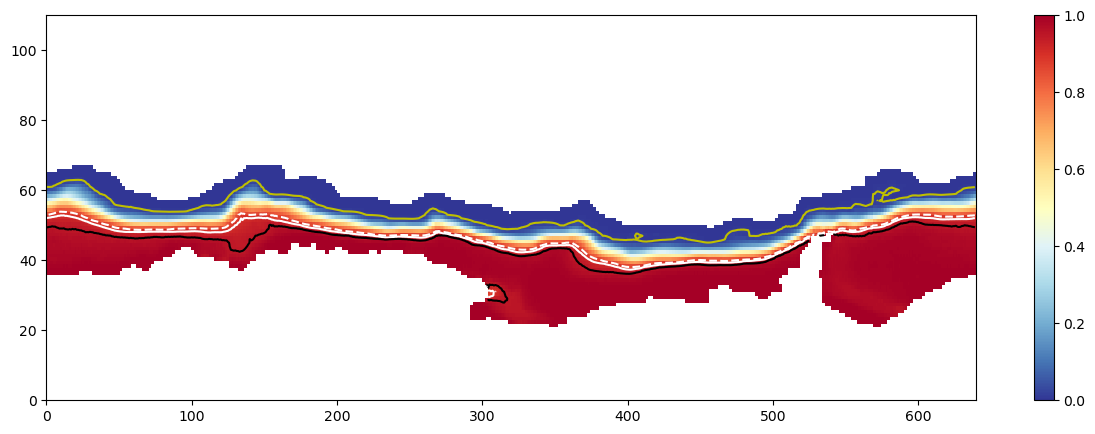

high res...


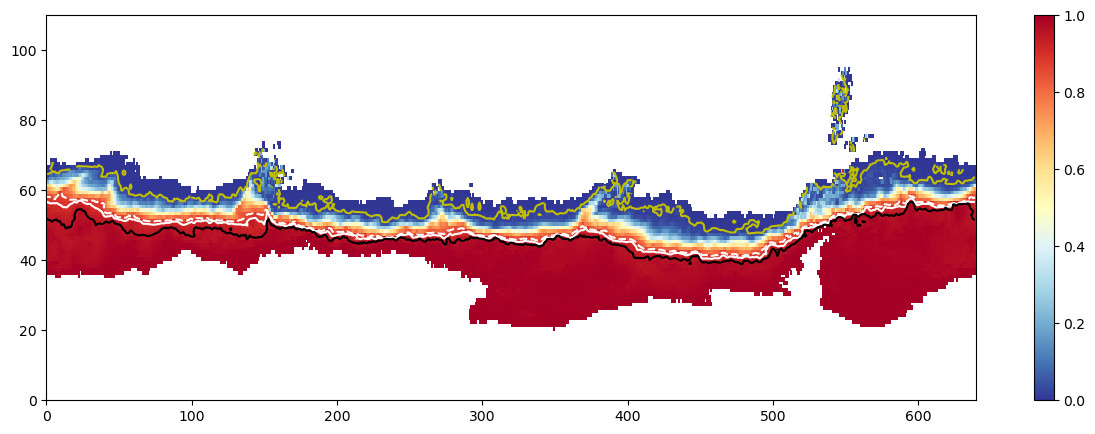

In [6]:
#---
# simple plot: sea ice 
#---

cmap1 = plt.cm.RdYlBu_r
v1,v2 = 0,1

print('low res...')
fig  = plt.figure(figsize=(15,5))
plt.pcolor(data_ice_max[0:110,:],cmap=cmap1,vmin=v1,vmax=v2)#,vmin=-10,vmax=10)
plt.colorbar()
plt.contour(data_ice_max[0:110,:],levels=[0.01,0.85,0.9,0.95],colors=['y','w','w','k'],linestyles=['-','--','-','-'])
plt.show()

print('high res...')
fig  = plt.figure(figsize=(15,5))
plt.pcolor(data_ice_max_hr[0:110,:],cmap=cmap1,vmin=v1,vmax=v2)#,vmin=-10,vmax=10)
plt.colorbar()
plt.contour(data_ice_max_hr[0:110,:],levels=[0.01,0.85,0.9,0.95],colors=['y','w','w','k'],linestyles=['-','--','-','-'])
plt.show()


In [7]:
#---
# plot map (TEST)
#---

plot_test = False

if plot_test:
    cmap1 = plt.cm.RdYlBu_r
    v1,v2   = 0,1
    v1b,v2b = 0,2
    indSO = 120

    print('full field, LR')
    fig  = plt.figure(figsize=(14,5))
    plt.pcolor(data1[0:indSO,:],cmap=cmap1,vmin=v1,vmax=v2)
    plt.colorbar()
    plt.show()

    print('full field, HR')
    fig  = plt.figure(figsize=(14,5))
    plt.pcolor(data2[0:indSO,:],cmap=cmap1,vmin=v1b,vmax=v2b)
    plt.colorbar()
    plt.show()
    
    print('emulator, LR')
    fig  = plt.figure(figsize=(14,5))
    plt.pcolor(data3[0:indSO,:],cmap=cmap1,vmin=v1,vmax=v2)
    plt.colorbar()
    plt.show()


In [8]:
#---
# FUNCTIONS
#---

def plot_SO_map(data_plot,data_plot_ice,lon2_plot,lat2_plot,contours_plot,levels1,cmap1,cticks1,clabel_string,filename1,plot_colorbar,save_plots,display_plots):

    fs = 12
    
    # projection
    projection=ccrs.SouthPolarStereo()

    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_extent([-280, 80, -80, -40], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
    #ax.coastlines(resolution='50m',zorder=51)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    mm1=ax.contourf(lon2_plot, lat2_plot, data_plot,\
                       levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
    if plot_colorbar:
        cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        cbar.set_label(clabel_string,fontsize=fs+5) #clabel_string
        cbar.ax.tick_params(labelsize=fs+4)
        cbar.ax.set_xticklabels(cticks_label)

    gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.5,\
                        color='grey', alpha=0.8,linestyle='--')#,xlabels_bottom=True)
    gl.top_labels = True
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels=True
    #gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-180,-120,-60,0,60,120]) 
    gl.ylocator = mticker.FixedLocator([-70,-60,-50])
    #gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.rotate_labels = False

    if contours_plot: # 
        lw = 1.5
        ax.contour(lon2_plot, lat2_plot, data_plot,levels = contours_plot,\
                             colors=['black','black','black'],linewidths=[lw,lw,lw],\
                       linestyles=['-','--',':'],transform=ccrs.PlateCarree())
        
    # add sea ice contour
    cs=ax.contour(lon2_plot,lat2_plot,data_plot_ice,levels=[0],\
           colors=['lightgrey','w','w'],linestyles=['-','--',':'],transform=ccrs.PlateCarree())


    dpicnt = 200
    if save_plots:
        if plot_colorbar:
            filename = filename1+'.png'
        else:
            filename = filename1+'_no_colorbar.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
        del filename
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        
    #----
    # if map is plotted without the colorbar, save colorbar separately
    #----
    if not plot_colorbar:
        dpicnt = 200
        
        # PNG
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(1, 1, 1, projection=projection)
        ax.set_extent([-280, 80, -80, -40], crs=ccrs.PlateCarree())
        ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
        mm1=ax.contourf(lon2_plot, lat2_plot, data_plot,\
                           levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
        plt.gca().set_visible(False)
        cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        cbar.set_label(clabel_string,fontsize=fs+5) #clabel_string
        cbar.ax.tick_params(labelsize=fs+4)
        cbar.ax.set_xticklabels(cticks_label)
        if save_plots:
            filename = filename1+'_COLROBAR.png'
            plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
            del filename
        if display_plots:
            plt.show()
        else:
            plt.close(fig)
            
        # EPS
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(1, 1, 1, projection=projection)
        ax.set_extent([-280, 80, -80, -40], crs=ccrs.PlateCarree())
        ax.add_feature(cartopy.feature.LAND,facecolor=("grey"),zorder=50)
        mm1=ax.contourf(lon2_plot, lat2_plot, data_plot,\
                           levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())
        plt.gca().set_visible(False)
        cbar = plt.colorbar(mm1,ax=ax,orientation='horizontal',fraction=0.075, pad=0.01,shrink=0.6,ticks=cticks1)
        cbar.ax.tick_params(labelsize=fs+4)
        cbar.ax.set_xticklabels([])
        if save_plots:
            filename = filename1+'_COLROBAR.eps'
            plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
            del filename
        if display_plots:
            plt.show()
        else:
            plt.close(fig)
            
            
        

low res (full field)...


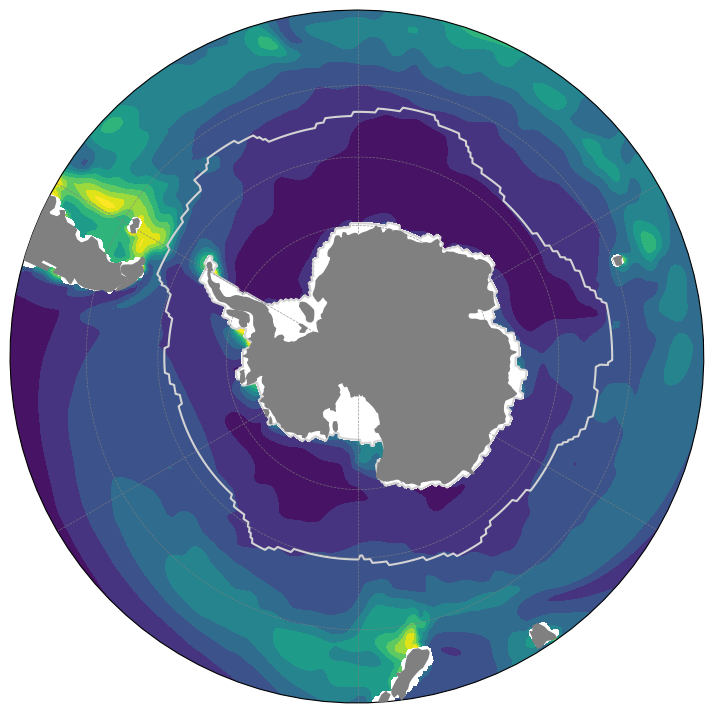

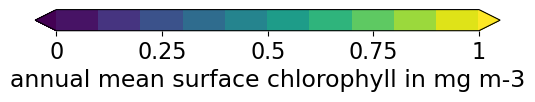

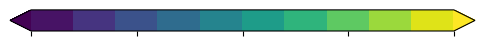

In [9]:
#---
# SO projection
#---
      

save_plots    = True
display_plots = True
plot_colorbar = False

cmap1 = plt.cm.viridis
clabel_string = 'annual mean surface chlorophyll in mg m-3'
contours_plot = [] # leave empty if no contours are wanted

#----
# add cyclic point
lon2_plot = np.nan*np.ones([320,641])
lat2_plot = np.nan*np.ones([320,641])
lon2_plot[:,0:640] = lon2
lon2_plot[:,640]   = lon[-1]+0.5625 # lon must increase further here (if I add "0", it looks odd)
lat2_plot[:,0:640] = lat2
lat2_plot[:,640]   = lat2[:,0]
#----


# LOW RES DATA
# add cyclic point
print('low res (full field)...')
data_aux  = np.copy(data1) # which data to plot?
data_plot = np.nan*np.ones([320,641])
data_plot[:,0:640] = data_aux
data_plot[:,640]   = data_aux[:,0]
#----
# sea ice data
data_aux  = np.copy(data_ice_max) # which data to plot?
data_plot_ice = np.nan*np.ones([320,641])
data_plot_ice[:,0:640] = data_aux
data_plot_ice[:,640]   = data_aux[:,0]
data_plot_ice[np.isnan(data_plot_ice)] = -1 # to make zero contour show up correctly
#----
levels1 = np.arange(0,1+0.1,0.1)
cticks1 = [0,0.25,0.5,0.75,1]
cticks_label = ['0','0.25','0.5','0.75','1']
filename1 = 'Annual_mean_srf_chl_low_res_'+str(year_list[0])+'_'+str(year_list[-1])
plot_SO_map(data_plot,data_plot_ice,lon2_plot,lat2_plot,contours_plot,levels1,cmap1,cticks1,clabel_string,filename1,plot_colorbar,save_plots,display_plots)


high res (full field)...


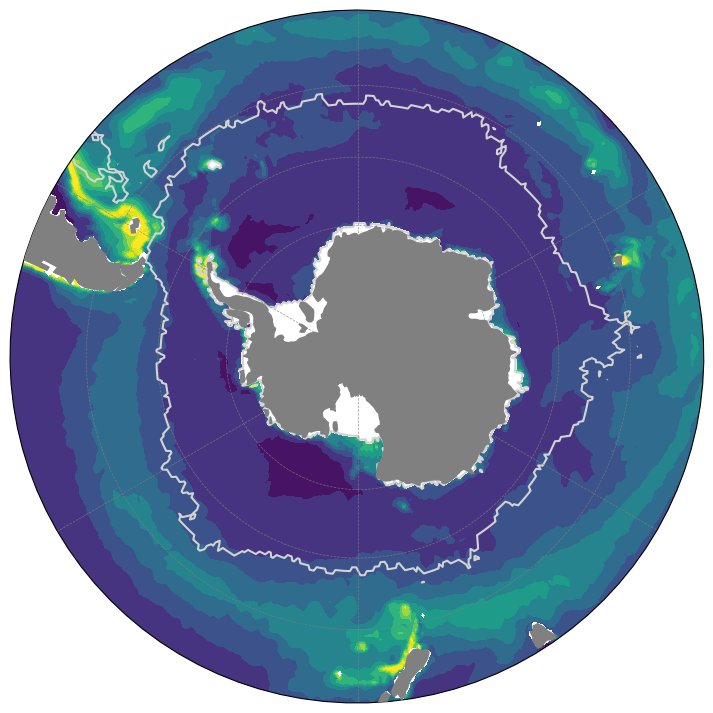

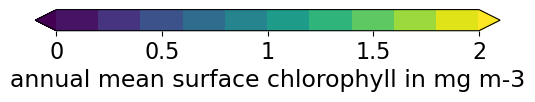

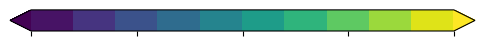

In [10]:

# HIGH RES DATA
# add cyclic point
print('high res (full field)...')
data_aux  = np.copy(data2) # which data to plot?
data_plot = np.nan*np.ones([320,641])
data_plot[:,0:640] = data_aux
data_plot[:,640]   = data_aux[:,0]
#----
# sea ice data
data_aux  = np.copy(data_ice_max_hr) # which data to plot?
data_plot_ice = np.nan*np.ones([320,641])
data_plot_ice[:,0:640] = data_aux
data_plot_ice[:,640]   = data_aux[:,0]
data_plot_ice[np.isnan(data_plot_ice)] = -1 # to make zero contour show up correctly
#----
levels1 = np.arange(0,2+0.2,0.2)
cticks1 = [0,0.5,1,1.5,2]
cticks_label = ['0','0.5','1','1.5','2']
filename1 = 'Annual_mean_srf_chl_high_res_'+str(year_list[0])+'_'+str(year_list[-1])
plot_SO_map(data_plot,data_plot_ice,lon2_plot,lat2_plot,contours_plot,levels1,cmap1,cticks1,clabel_string,filename1,plot_colorbar,save_plots,display_plots)


low res (emulator)...


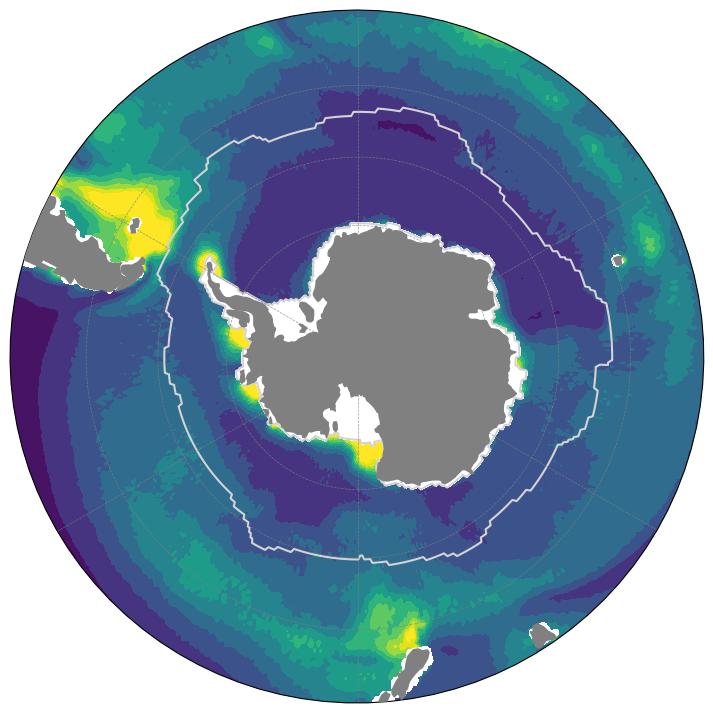

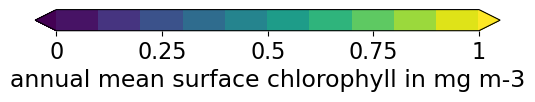

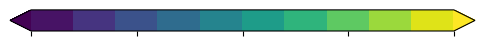

In [11]:

# LOW RES DATA, EMULATOR
# add cyclic point
print('low res (emulator)...')
data_aux  = np.copy(data3) # which data to plot?
data_plot = np.nan*np.ones([320,641])
data_plot[:,0:640] = data_aux
data_plot[:,640]   = data_aux[:,0]
#----
# sea ice data
data_aux  = np.copy(data_ice_max) # which data to plot?
data_plot_ice = np.nan*np.ones([320,641])
data_plot_ice[:,0:640] = data_aux
data_plot_ice[:,640]   = data_aux[:,0]
data_plot_ice[np.isnan(data_plot_ice)] = -1 # to make zero contour show up correctly
#----
levels1 = np.arange(0,1+0.1,0.1)
cticks1 = [0,0.25,0.5,0.75,1]
cticks_label = ['0','0.25','0.5','0.75','1']
filename1 = 'Annual_mean_srf_chl_low_res_EMULATOR_'+str(year_list[0])+'_'+str(year_list[-1])
plot_SO_map(data_plot,data_plot_ice,lon2_plot,lat2_plot,contours_plot,levels1,cmap1,cticks1,clabel_string,filename1,plot_colorbar,save_plots,display_plots)


/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


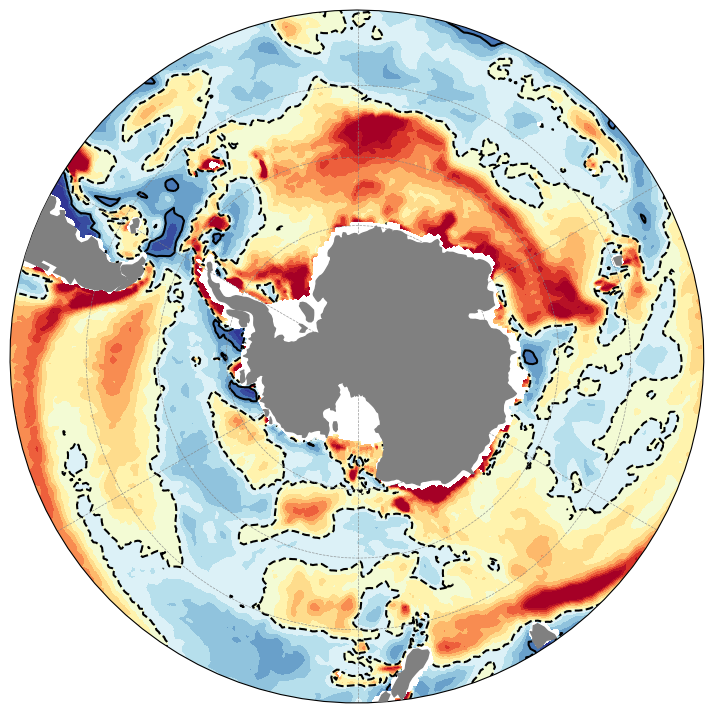

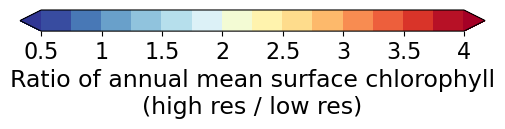

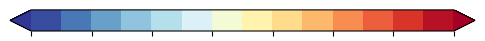

In [13]:
#---
# plot ratio between HIGH RES and LOW RES (both full field)
#---

cmap1 = plt.cm.RdYlBu_r
clabel_string = 'Ratio of annual mean surface chlorophyll\n(high res / low res)'
contours_plot = [1,2] # leave empty if no contours are wanted

# HIGH RES DATA vs LOW RES DATA
# add cyclic point
data_aux  = np.copy(data2/data1) # which data to plot?
data_plot = np.nan*np.ones([320,641])
data_plot[:,0:640] = data_aux
data_plot[:,640]   = data_aux[:,0]
levels1 = np.arange(0.5,4+0.25,0.25)
cticks1 = [0.5,1,1.5,2,2.5,3,3.5,4]
cticks_label = ['0.5','1','1.5','2','2.5','3','3.5','4']
filename1 = 'Annual_mean_srf_chl_high_res_vs_low_res_'+str(year_list[0])+'_'+str(year_list[-1])
plot_SO_map(data_plot,-999*np.ones_like(data_plot_ice),lon2_plot,lat2_plot,contours_plot,levels1,cmap1,cticks1,clabel_string,filename1,plot_colorbar,save_plots,display_plots)


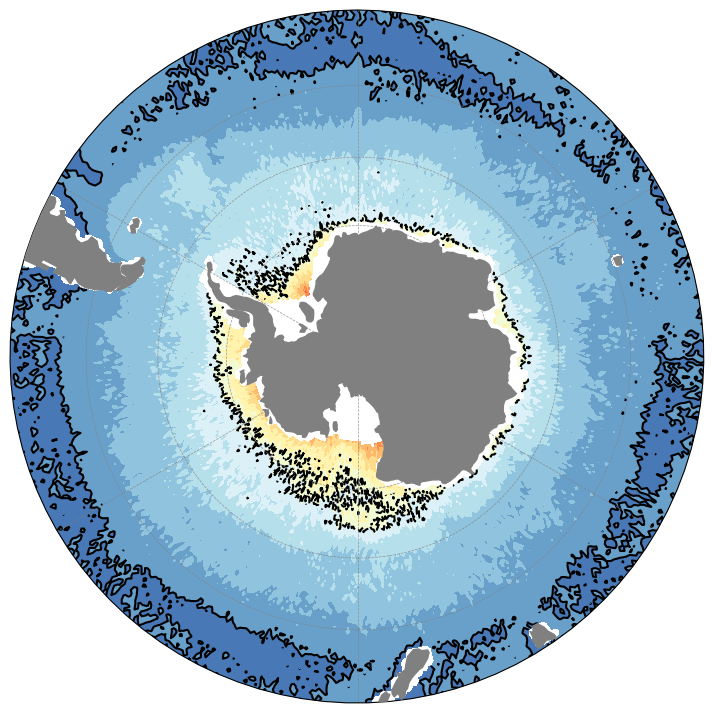

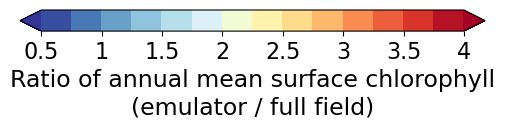

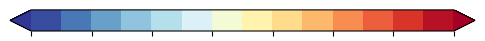

In [15]:
#---
# plot ratio between LOW RES (full field) and LOW RES (emulator)
#---

cmap1 = plt.cm.RdYlBu_r
clabel_string = 'Ratio of annual mean surface chlorophyll\n(emulator / full field)'
contours_plot = [1,2] # leave empty if no contours are wanted

# HIGH RES DATA vs LOW RES DATA
# add cyclic point
data_aux  = np.copy(data3/data1) # which data to plot?
data_plot = np.nan*np.ones([320,641])
data_plot[:,0:640] = data_aux
data_plot[:,640]   = data_aux[:,0]
levels1 = np.arange(0.5,4+0.25,0.25)
cticks1 = [0.5,1,1.5,2,2.5,3,3.5,4]
cticks_label = ['0.5','1','1.5','2','2.5','3','3.5','4']
filename1 = 'Annual_mean_srf_chl_low_res_full_field_vs_EMULATOR_'+str(year_list[0])+'_'+str(year_list[-1])
plot_SO_map(data_plot,-999*np.ones_like(data_plot_ice),lon2_plot,lat2_plot,contours_plot,levels1,cmap1,cticks1,clabel_string,filename1,plot_colorbar,save_plots,display_plots)


In [ ]:
print(savepath)